### Name: Riya Shyam Huddar
### Roll no: MDS202431
### Applied Machine Learning Assignment 2

In [ ]:
# Install dependencies
!pip install --user dvc
!pip install "dvc[gdrive]"

In [1]:
# Imports
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [3]:
# Initialize Git repository
!git init

Initialized empty Git repository in D:/CMI/AppliedML/Assignment 2/.git/


We update the `.gitignore` file to:
- Ignore Jupyter notebook checkpoints
- Prevent CSV data files from being tracked by Git (they will be tracked using DVC instead)
- Ignore extracted dataset folders
- .env file

In [8]:
# Create or update .gitignore file
with open(".gitignore", "w") as f:
    f.write(
        ".ipynb_checkpoints/\n"
        "*.csv\n"
        "SMSSpamCollection\n"
        "sms+spam+collection/\n"
        ".env\n"
    )

In [10]:
os.getcwd()

'D:\\CMI\\AppliedML\\Assignment 2'

In [12]:
!"{sys.executable}" -m dvc --version

3.66.1


We initialize DVC inside the Git repository.  
DVC will manage large data files separately from Git while keeping metadata tracked in Git.

In [14]:
!"{sys.executable}" -m dvc init

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/treeverse/dvc>


After initializing DVC, we commit the generated files to Git.
Git tracks:
- DVC configuration files
- `.dvc/` directory
- `.dvcignore`

In [16]:
!git add .
!git commit -m "Initialize DVC"

[master (root-commit) 8a956ef] Initialize DVC
 6 files changed, 2829 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 .gitignore
 create mode 100644 prepare.ipynb
 create mode 100644 train.ipynb


---

### Step 1: Loading and Pre-processing

### Loading the data
We load the SMS Spam Collection dataset from the local file.

The dataset consists of:
- `label` (ham/spam)
- `message` (SMS text)

We split each line using the first tab character and convert the data into a Pandas DataFrame.


In [18]:
# load data from local filepath
def load_data(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # split only on the first tab
            if "\t" in line:
                label, text = line.split("\t", 1)
                data.append([label, text])
    df = pd.DataFrame(data, columns=["label", "message"])
    return df

DATA_PATH = r"SMSSpamCollection"
df = load_data(DATA_PATH)
print("Total rows loaded:", len(df))
df.head()


Total rows loaded: 5574


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Encode Target Variable

We convert the categorical labels into numerical format:

- ham -> 0
- spam -> 1

The original `label` column is dropped after encoding.


In [20]:
# Label encoding
df["target"] = df["label"].map({"ham": 0, "spam": 1})
df = df.drop(columns=["label"])

In [22]:
# Print first few rows
df.head()

,message,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### Exploratory Data Analysis

- The dataset contains 5,574 samples.
- It is imbalanced (≈86.6% ham, 13.4% spam).
- No missing values are present.
- There are 414 duplicate messages.

In [24]:
print("Dataset shape:", df.shape)

print("\nClass distribution:")
print(df["target"].value_counts())

print("\nClass percentage:")
print(df["target"].value_counts(normalize=True) * 100)

print("\nMissing values:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())


Dataset shape: (5574, 2)

Class distribution:
target
0    4827
1     747
Name: count, dtype: int64

Class percentage:
target
0    86.598493
1    13.401507
Name: proportion, dtype: float64

Missing values:
message    0
target     0
dtype: int64

Duplicate rows: 414


### Additional Feature Exploration

We analyze message length and word count to understand structural differences 
between ham and spam messages.

Spam messages are generally longer and contain more words compared to ham messages.


In [26]:
df["message_length"] = df["message"].apply(len)
df.groupby("target")["message_length"].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4827.0,71.440025,58.322011,2.0,33.0,52.0,93.0,910.0
1,747.0,138.634538,28.854103,13.0,133.0,149.0,157.0,223.0


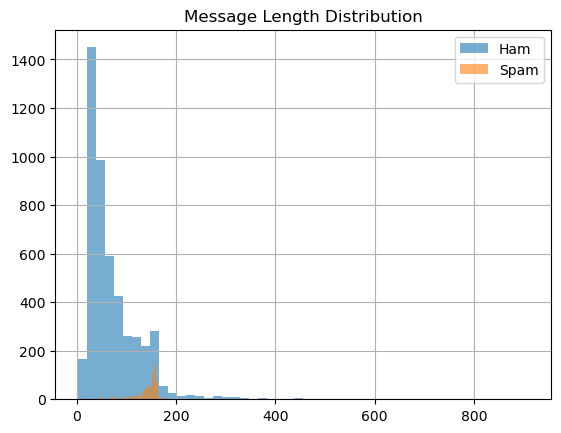

In [28]:
df[df["target"] == 0]["message_length"].hist(alpha=0.6, bins=50)
df[df["target"] == 1]["message_length"].hist(alpha=0.6, bins=50)

plt.legend(["Ham", "Spam"])
plt.title("Message Length Distribution")
plt.show()

In [30]:
df["word_count"] = df["message"].apply(lambda x: len(x.split()))
df.groupby("target")["word_count"].mean()

target
0    14.304123
1    23.911647
Name: word_count, dtype: float64

### Text Preprocessing

We preprocess SMS messages before saving the raw dataset.

Preprocessing steps:
1. Convert text to lowercase
2. Replace URLs with placeholder token `url`
3. Remove unnecessary punctuation (retain !, ?, $, numbers)
4. Remove empty messages
5. Remove duplicate rows

The cleaned dataset is saved as `raw_data.csv` for DVC tracking.


In [32]:
import re

def preprocess_text(text):
    """
    Preprocess SMS text for spam classification.
    
    Steps:
    1. Lowercase all text
    2. Remove unnecessary punctuation (keep !, ?, $, numbers, URLs)
    3. Retain stopwords and original word forms (no stemming/lemmatization)
    """
    # Lowercase
    text = text.lower()
    
    # Remove URLs but keep the word "url" as a placeholder
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text)
    
    # Remove unnecessary punctuation except !, ?, $, numbers
    # Keep letters, numbers, spaces, ! ? $
    text = re.sub(r"[^a-z0-9!?$ ]", " ", text)
    
    # Collapse multiple spaces to one
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


In [34]:
df["message"] = df["message"].apply(preprocess_text)

print("After preprocessing:", df.shape)
df.head()


After preprocessing: (5574, 4)


,message,target,message_length,word_count
0,go until jurong point crazy available only in ...,0,111,20
1,ok lar joking wif u oni,0,29,6
2,free entry in 2 a wkly comp to win fa cup fina...,1,155,28
3,u dun say so early hor u c already then say,0,49,11
4,nah i don t think he goes to usf he lives arou...,0,61,13


In [36]:
df = df[df["message"].str.strip() != ""]
df = df.drop_duplicates()

print("After removing empty & duplicates:", df.shape)

After removing empty & duplicates: (5156, 4)


In [38]:
df = df[["target", "message"]]
df.to_csv("raw_data.csv", index=False)
print("raw_data.csv saved successfully.")

raw_data.csv saved successfully.


In [40]:
!"{sys.executable}" -m dvc add raw_data.csv
!git add raw_data.csv.dvc
!git commit -m "Add raw_data.csv to DVC"


To track the changes with git, run:

	git add raw_data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


\u280b Checking graph



[master b8b0396] Add raw_data.csv to DVC
 1 file changed, 5 insertions(+)
 create mode 100644 raw_data.csv.dvc


----

### Step 2: Create Train/Validation/Test Splits

We split the dataset using stratified sampling to preserve class distribution.

Split proportions:
- Train: 70%
- Validation: 15%
- Test: 15%

We use a fixed random seed 99 to ensure reproducibility.

The split files are tracked using DVC.


In [42]:
from sklearn.model_selection import train_test_split

def create_splits(seed):
    df = pd.read_csv("raw_data.csv")
    
    X = df.drop("target", axis=1)
    y = df["target"]

    # First split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.3,
        random_state=seed,
        stratify=y
    )

    # Second split
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=seed,
        stratify=y_temp
    )

    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    train.to_csv("train.csv", index=False)
    val.to_csv("validation.csv", index=False)
    test.to_csv("test.csv", index=False)

    print(f"\nSplits created with seed={seed}")
    print("Train:", train.shape)
    print("Validation:", val.shape)
    print("Test:", test.shape)

In [44]:
create_splits(seed=99)


Splits created with seed=99
Train: (3609, 2)
Validation: (773, 2)
Test: (774, 2)


In [46]:
!"{sys.executable}" -m dvc add train.csv validation.csv test.csv


To track the changes with git, run:

	git add train.csv.dvc test.csv.dvc validation.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


\u280b Checking graph



In [48]:
!git add train.csv.dvc validation.csv.dvc test.csv.dvc
!git commit -m "First data split version (seed=99)"

[master ee9794a] First data split version (seed=99)
 3 files changed, 15 insertions(+)
 create mode 100644 test.csv.dvc
 create mode 100644 train.csv.dvc
 create mode 100644 validation.csv.dvc


### Update Split with Different Random Seed

We regenerate the train/validation/test splits using a different random seed- 17.

This creates a new version of the dataset splits.

DVC tracks the updated split files, allowing us to switch between versions.


In [50]:
create_splits(seed=17)


Splits created with seed=17
Train: (3609, 2)
Validation: (773, 2)
Test: (774, 2)


In [52]:
!"{sys.executable}" -m dvc add train.csv validation.csv test.csv


To track the changes with git, run:

	git add test.csv.dvc train.csv.dvc validation.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


\u280b Checking graph



In [54]:
!git add train.csv.dvc validation.csv.dvc test.csv.dvc
!git commit -m "Updated split version (seed=17)"

[master 955b170] Updated split version (seed=17)
 3 files changed, 6 insertions(+), 6 deletions(-)


In [56]:
!git log --oneline

955b170 Updated split version (seed=17)
ee9794a First data split version (seed=99)
b8b0396 Add raw_data.csv to DVC
8a956ef Initialize DVC


---

### Step 3: Verification

### Checkout First Split Version (seed=99)

We checkout the earlier commit corresponding to the first data split.
After running `dvc checkout`, the train/validation/test files are restored
to their previous version.

We then print the class distribution for each split.

Observation:

Although the class distributions remain identical due to stratified sampling,
the actual data samples differ between random seeds.

This is confirmed by comparing `train.head()` across versions.



In [58]:
!git checkout ee9794a  

M	prepare.ipynb


Note: switching to 'ee9794a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ee9794a First data split version (seed=99)


In [60]:
!"{sys.executable}" -m dvc checkout

M       test.csv
M       train.csv
M       validation.csv


In [62]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

print("Train distribution:")
print(train["target"].value_counts())

print("\nValidation distribution:")
print(val["target"].value_counts())

print("\nTest distribution:")
print(test["target"].value_counts())

Train distribution:
target
0    3160
1     449
Name: count, dtype: int64

Validation distribution:
target
0    677
1     96
Name: count, dtype: int64

Test distribution:
target
0    678
1     96
Name: count, dtype: int64


In [64]:
train.head()

,message,target
0,i fetch yun or u fetch?,0
1,urgent! you have won a 1 week free membership ...,1
2,i couldn t say no as he is a dying man and i f...,0
3,and smile for me right now as you go and the w...,0
4,wait 4 me in sch i finish ard 5,0


### Checkout Updated Split Version (seed=17)

We switch to the commit corresponding to the updated split version.
After running `dvc checkout`, the train/validation/test files are restored
to this version.

We print the class distribution to compare with the previous version.


In [66]:
!git checkout 955b170  

M	prepare.ipynb


Previous HEAD position was ee9794a First data split version (seed=99)
HEAD is now at 955b170 Updated split version (seed=17)


In [68]:
!"{sys.executable}" -m dvc checkout

M       test.csv
M       train.csv
M       validation.csv


In [70]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

print("Train distribution:")
print(train["target"].value_counts())

print("\nValidation distribution:")
print(val["target"].value_counts())

print("\nTest distribution:")
print(test["target"].value_counts())

Train distribution:
target
0    3160
1     449
Name: count, dtype: int64

Validation distribution:
target
0    677
1     96
Name: count, dtype: int64

Test distribution:
target
0    678
1     96
Name: count, dtype: int64


In [72]:
train.head()

,message,target
0,pls go there today lt gt i dont want any excuses,0
1,can i m free,0
2,then u go back urself lor,0
3,i know i m lacking on most of this particular ...,0
4,and you! will expect you whenever you text! ho...,0


In [74]:
!git log --oneline

955b170 Updated split version (seed=17)
ee9794a First data split version (seed=99)
b8b0396 Add raw_data.csv to DVC
8a956ef Initialize DVC


### Inspect DVC Metadata Differences

We inspected the `.dvc` files across different commits using `git show`.  
The `.dvc` files store the MD5 hash, file size, and file path of the tracked data.

The differing MD5 hashes and file sizes between commits confirm that the
train/validation/test splits are different versions.  

This demonstrates that DVC tracks dataset changes using content hashing,
while Git manages the corresponding metadata files.


In [80]:
!git show --oneline ee9794a  :train.csv.dvc

ee9794a First data split version (seed=99)
diff --git a/test.csv.dvc b/test.csv.dvc
new file mode 100644
index 0000000..fc07b21
--- /dev/null
+++ b/test.csv.dvc
@@ -0,0 +1,5 @@
+outs:
+- md5: 8e7fa2c98713308adc298bcce390027a
+  size: 62913
+  hash: md5
+  path: test.csv
diff --git a/train.csv.dvc b/train.csv.dvc
new file mode 100644
index 0000000..bd36b15
--- /dev/null
+++ b/train.csv.dvc
@@ -0,0 +1,5 @@
+outs:
+- md5: 5ed10f48c1edc4454a6854efaa3237e9
+  size: 287885
+  hash: md5
+  path: train.csv
diff --git a/validation.csv.dvc b/validation.csv.dvc
new file mode 100644
index 0000000..4dc0e61
--- /dev/null
+++ b/validation.csv.dvc
@@ -0,0 +1,5 @@
+outs:
+- md5: b08a02c25462d2304112e036fb6234a2
+  size: 60512
+  hash: md5
+  path: validation.csv
outs:
- md5: c86dc97e77b28720e59c5d9ccc124a53
  size: 288222
  hash: md5
  path: train.csv


In [78]:
!git show --oneline 955b170  :train.csv.dvc

955b170 Updated split version (seed=17)
diff --git a/test.csv.dvc b/test.csv.dvc
index fc07b21..820087f 100644
--- a/test.csv.dvc
+++ b/test.csv.dvc
@@ -1,5 +1,5 @@
 outs:
-- md5: 8e7fa2c98713308adc298bcce390027a
-  size: 62913
+- md5: ccffc735f6d1a5133093c43634f10419
+  size: 61492
   hash: md5
   path: test.csv
diff --git a/train.csv.dvc b/train.csv.dvc
index bd36b15..06cc7ef 100644
--- a/train.csv.dvc
+++ b/train.csv.dvc
@@ -1,5 +1,5 @@
 outs:
-- md5: 5ed10f48c1edc4454a6854efaa3237e9
-  size: 287885
+- md5: c86dc97e77b28720e59c5d9ccc124a53
+  size: 288222
   hash: md5
   path: train.csv
diff --git a/validation.csv.dvc b/validation.csv.dvc
index 4dc0e61..9f5006d 100644
--- a/validation.csv.dvc
+++ b/validation.csv.dvc
@@ -1,5 +1,5 @@
 outs:
-- md5: b08a02c25462d2304112e036fb6234a2
-  size: 60512
+- md5: f40c9204ad9723309091c1b60c74e42b
+  size: 61596
   hash: md5
   path: validation.csv
outs:
- md5: c86dc97e77b28720e59c5d9ccc124a53
  size: 288222
  hash: md5
  path: train.csv


---

### Bonus: Decoupling Compute and Storage using Google Drive

To decouple storage from computation, we configure a remote DVC storage
using Google Drive.

This allows dataset versions to be stored remotely while Git tracks
only metadata locally.

We push all tracked dataset versions to the remote storage.


In [82]:
!"{sys.executable}" -m dvc remote add -d myremote gdrive://root/dvc_storage

Setting 'myremote' as a default remote.


In [84]:
# Load variables from .env file
load_dotenv()

client_id = os.getenv("GDRIVE_CLIENT_ID")
client_secret = os.getenv("GDRIVE_CLIENT_SECRET")

print("Client ID loaded:", client_id is not None)
print("Client Secret loaded:", client_secret is not None)


Client ID loaded: True
Client Secret loaded: True


In [86]:
!"{sys.executable}" -m dvc remote modify --local myremote gdrive_client_id "{client_id}"
!"{sys.executable}" -m dvc remote modify --local myremote gdrive_client_secret "{client_secret}"

In [90]:
!"{sys.executable}" -m dvc push

4 files pushed


In [92]:
!git checkout ee9794a 

M	.dvc/config
M	prepare.ipynb


Previous HEAD position was 955b170 Updated split version (seed=17)
HEAD is now at ee9794a First data split version (seed=99)


In [94]:
!"{sys.executable}" -m dvc push

3 files pushed


In [96]:
!"{sys.executable}" -m dvc remote list

myremote        gdrive://root/dvc_storage       (default)


---

### Summary of Data Version Control

- Dataset splits were versioned using DVC.
- Different random seeds created different dataset versions.
- DVC allowed switching between versions reproducibly.
- Google Drive remote was configured to decouple storage from compute.
